## Load Data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Set max_columns to None to always display all columns
pd.set_option('display.max_columns', None)

# Updated city details with OSMID and target date
city_details = {
    "Stockholm": {"osmid": "398021", "date": "2024-06-20"},
    "Amsterdam": {"osmid": "271110", "date": "2024-06-20"},
    "Boston": {"osmid": "2315704", "date": "2024-06-20"},
    # "Cambridge": {"osmid": "1933745", "date": "2024-06-20"},
    "Tunis": {"osmid": "8896976", "date": "2024-06-20"},
    "Hong Kong": {"osmid": "913110", "date": "2025-06-20"},
    "Singapore": {"osmid": "536780", "date": "2024-03-20"},
    "Belem": {"osmid": "185567", "date": "2025-03-20"},
    "Rio": {"osmid": "2697338", "date": "2025-12-21"},
    "Cape Town": {"osmid": "79604", "date": "2024-12-21"},
    "Sydney": {"osmid": "1251066", "date": "2025-12-21"},
}

# Enable test run and visualization toggle if needed
test_run = False
visualize = False
if test_run:
    city_details = {k: city_details[k] for k in list(city_details.keys())[:2]}

# Base path to the folders containing city files
base_path = "../results/output"

# First, load (and combine) raw data by city key.
# For Boston and Cambridge, use the same key ("Boston").
combined_city_data = {}  # key -> combined GeoDataFrame
for city, details in city_details.items():
    # Use "Boston" as the key for both Boston and Cambridge
    key = "Boston" if city in ["Boston", "Cambridge"] else city
    osmid = details["osmid"]
    target_date = details["date"]
    file_path = f"{base_path}/{osmid}/{osmid}_sidewalks_with_stats_multiple_dates.gpkg"
    
    try:
        city_data = gpd.read_file(file_path, engine='pyogrio')
        # If the key already exists, append (concatenate) the new data;
        # otherwise, start with this GeoDataFrame.
        if key in combined_city_data:
            combined_city_data[key] = pd.concat([combined_city_data[key], city_data], ignore_index=True)
        else:
            combined_city_data[key] = city_data
        print(f"Loaded data for {city} into key '{key}'.")
    except FileNotFoundError:
        print(f"File not found for {city} at {file_path}. Skipping...")

# Now process each (possibly combined) city's data to compute the time-series.
processed_building_shade = {}
processed_tree_shade = {}
all_hours = range(48)  # 48 slots for 30-minute intervals (0:00 to 24:00)

for key, city_data in combined_city_data.items():
    # Determine the target date.
    # For Boston (the combined key), we assume Boston’s target date.
    target_date = city_details["Boston"]["date"] if key == "Boston" else city_details[key]["date"]
    date_str = target_date.replace("-", "")
    
    # Build a regex to match columns like: YYYYMMDD_(building|tree)_shade_percent_at_(\d+)
    column_pattern = rf"{date_str}_(building|tree)_shade_percent_at_(\d+)"
    matched_columns = [col for col in city_data.columns if re.match(column_pattern, col)]
    if not matched_columns:
        print(f"No data columns for {key} on {target_date}. Skipping...")
        continue

    # Separate building and tree columns
    building_columns = [col for col in matched_columns if "_building_" in col]
    tree_columns = [col for col in matched_columns if "_tree_" in col]
    
    # Get the times (as integers) from the column names using a regex pattern.
    time_pattern = rf"{date_str}_(building|tree)_shade_percent_at_(\d+)"
    building_times = [int(re.search(time_pattern, col).group(2)) for col in building_columns]
    tree_times = [int(re.search(time_pattern, col).group(2)) for col in tree_columns]
    
    # Sort columns by time
    sorted_building_columns = [col for _, col in sorted(zip(building_times, building_columns))]
    sorted_tree_columns = [col for _, col in sorted(zip(tree_times, tree_columns))]
    
    # Create arrays for full 24-hour coverage (default value 100%)
    building_full = np.full(len(all_hours), 100.0)
    tree_full = np.full(len(all_hours), 100.0)
    
    # A helper function to map a time (e.g., 930 for 9:30) to an index (0 to 47)
    def normalize_time_to_index(time):
        hour = time // 100
        minute = time % 100
        return hour * 2 + minute // 30

    building_indices = [normalize_time_to_index(t) for t in building_times]
    tree_indices = [normalize_time_to_index(t) for t in tree_times]
    
    # Fill the arrays with the average values from the combined GeoDataFrame.
    for idx, col in zip(building_indices, sorted_building_columns):
        if idx < len(all_hours):
            building_full[idx] = city_data[col].mean()
    for idx, col in zip(tree_indices, sorted_tree_columns):
        if idx < len(all_hours):
            tree_full[idx] = city_data[col].mean()
    
    processed_building_shade[key] = building_full
    processed_tree_shade[key] = tree_full
    print(f"Processed data for {key}.")

# Create DataFrames for further analysis or plotting.
city_names = list(processed_building_shade.keys())
time_labels = [f"{h//2:02}:{(h%2)*30:02}" for h in all_hours]

building_shade_df = pd.DataFrame(
    [processed_building_shade[city] for city in city_names],
    index=city_names,
    columns=time_labels
)
tree_shade_df = pd.DataFrame(
    [processed_tree_shade[city] for city in city_names],
    index=city_names,
    columns=time_labels
)

# Preview the DataFrames
print("\nBuilding Shade DataFrame:")
print(building_shade_df.head())

print("\nTree Shade DataFrame:")
print(tree_shade_df.head())


Loaded data for Stockholm into key 'Stockholm'.
Loaded data for Amsterdam into key 'Amsterdam'.
Loaded data for Boston into key 'Boston'.
Loaded data for Tunis into key 'Tunis'.
Loaded data for Hong Kong into key 'Hong Kong'.
Loaded data for Singapore into key 'Singapore'.
Loaded data for Belem into key 'Belem'.
Loaded data for Rio into key 'Rio'.
Loaded data for Cape Town into key 'Cape Town'.
Loaded data for Sydney into key 'Sydney'.
Processed data for Stockholm.
Processed data for Amsterdam.
Processed data for Boston.
Processed data for Tunis.
Processed data for Hong Kong.
Processed data for Singapore.
Processed data for Belem.
Processed data for Rio.
Processed data for Cape Town.
Processed data for Sydney.

Building Shade DataFrame:
           00:00  00:30  01:00  01:30  02:00  02:30       03:00       03:30  \
Stockholm  100.0  100.0  100.0  100.0  100.0  100.0   91.110865   82.919447   
Amsterdam  100.0  100.0  100.0  100.0  100.0  100.0  100.000000  100.000000   
Boston     100.0

## City Comparison

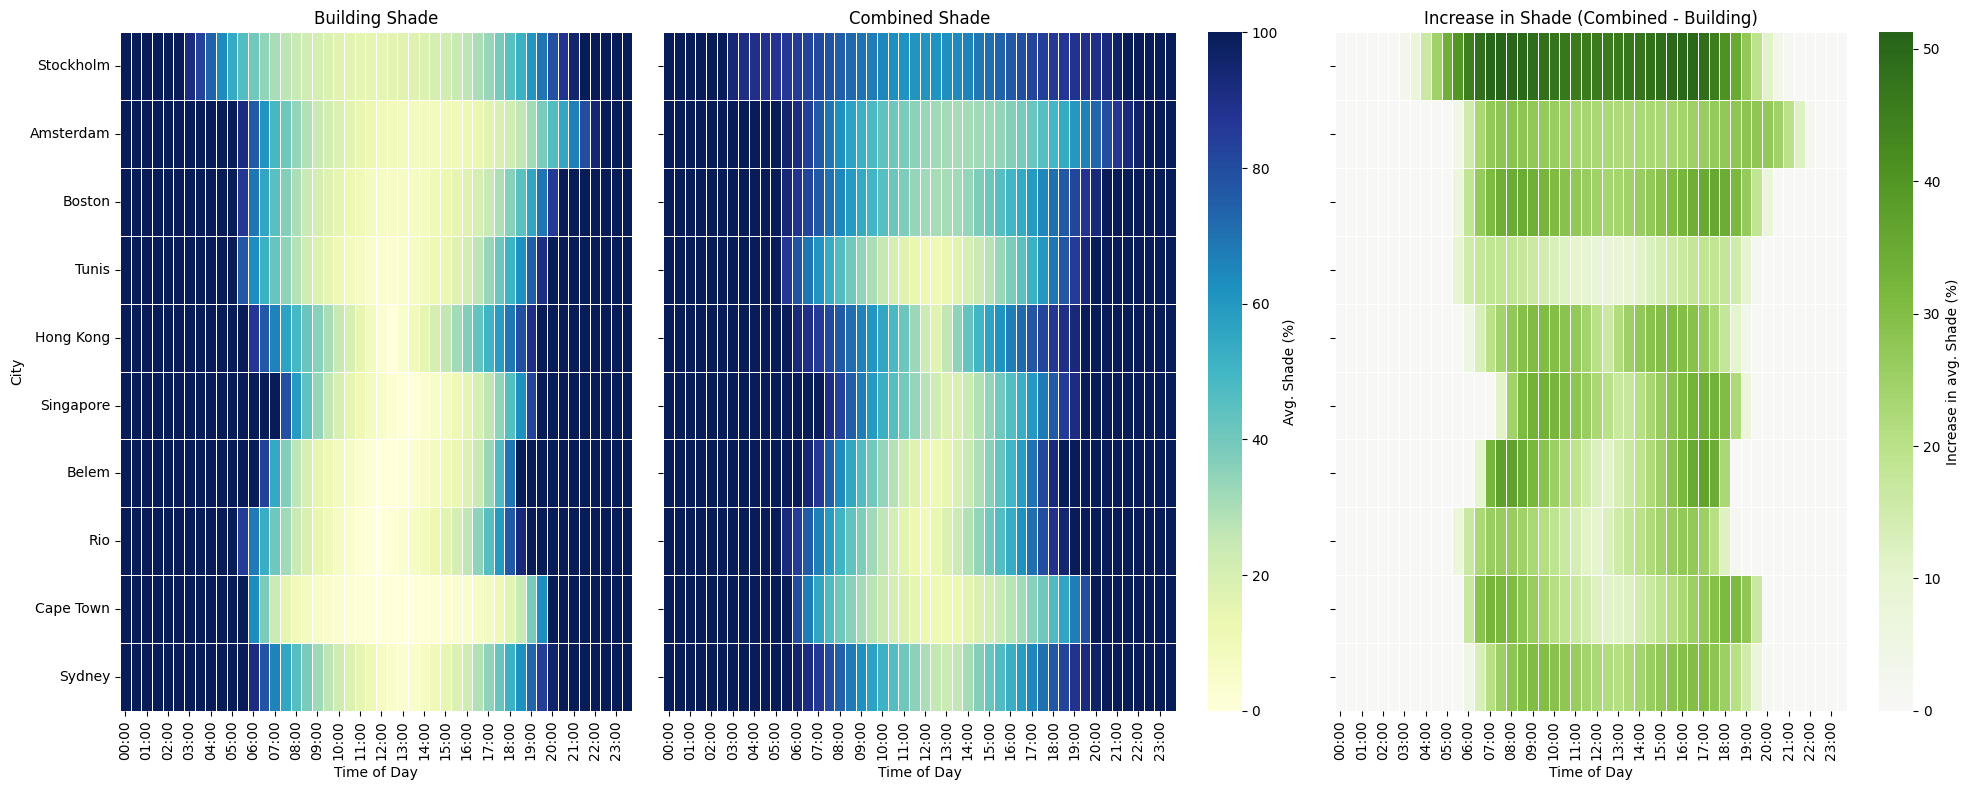

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the difference between combined shade and building shade
shade_diff = tree_shade_df - building_shade_df

# Define a common scale for the building and combined shade heatmaps
shade_vmin = 0
shade_vmax = 100

# Create a figure with three subplots.
# Adjust the width ratios so that the first plot (without a colorbar) is made slightly narrower.
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True, 
                           gridspec_kw={'width_ratios': [0.8, 1, 1]})

# Plot 1: Building shade heatmap (no colorbar)
sns.heatmap(
    building_shade_df,
    ax=axes[0],
    cmap="YlGnBu",
    vmin=shade_vmin,
    vmax=shade_vmax,
    cbar=False,       # remove the colorbar here
    linewidths=0.5
)
axes[0].set_title("Building Shade")
axes[0].set_ylabel("City")
axes[0].set_xlabel("Time of Day")

# Plot 2: Combined shade heatmap (with colorbar)
sns.heatmap(
    tree_shade_df,
    ax=axes[1],
    cmap="YlGnBu",
    vmin=shade_vmin,
    vmax=shade_vmax,
    cbar_kws={'label': 'Avg. Shade (%)'},
    linewidths=0.5
)
axes[1].set_title("Combined Shade")
axes[1].set_xlabel("Time of Day")

# Plot 3: Difference heatmap (with colorbar)
sns.heatmap(
    shade_diff,
    ax=axes[2],
    cmap="PiYG",   # diverging colormap for differences
    center=0,          # center the colormap at 0 for the difference plot
    cbar_kws={'label': 'Increase in avg. Shade (%)'},
    linewidths=0.5
)
axes[2].set_title("Increase in Shade (Combined - Building)")
axes[2].set_xlabel("Time of Day")

plt.tight_layout()
plt.show()

### Comparison without third row:

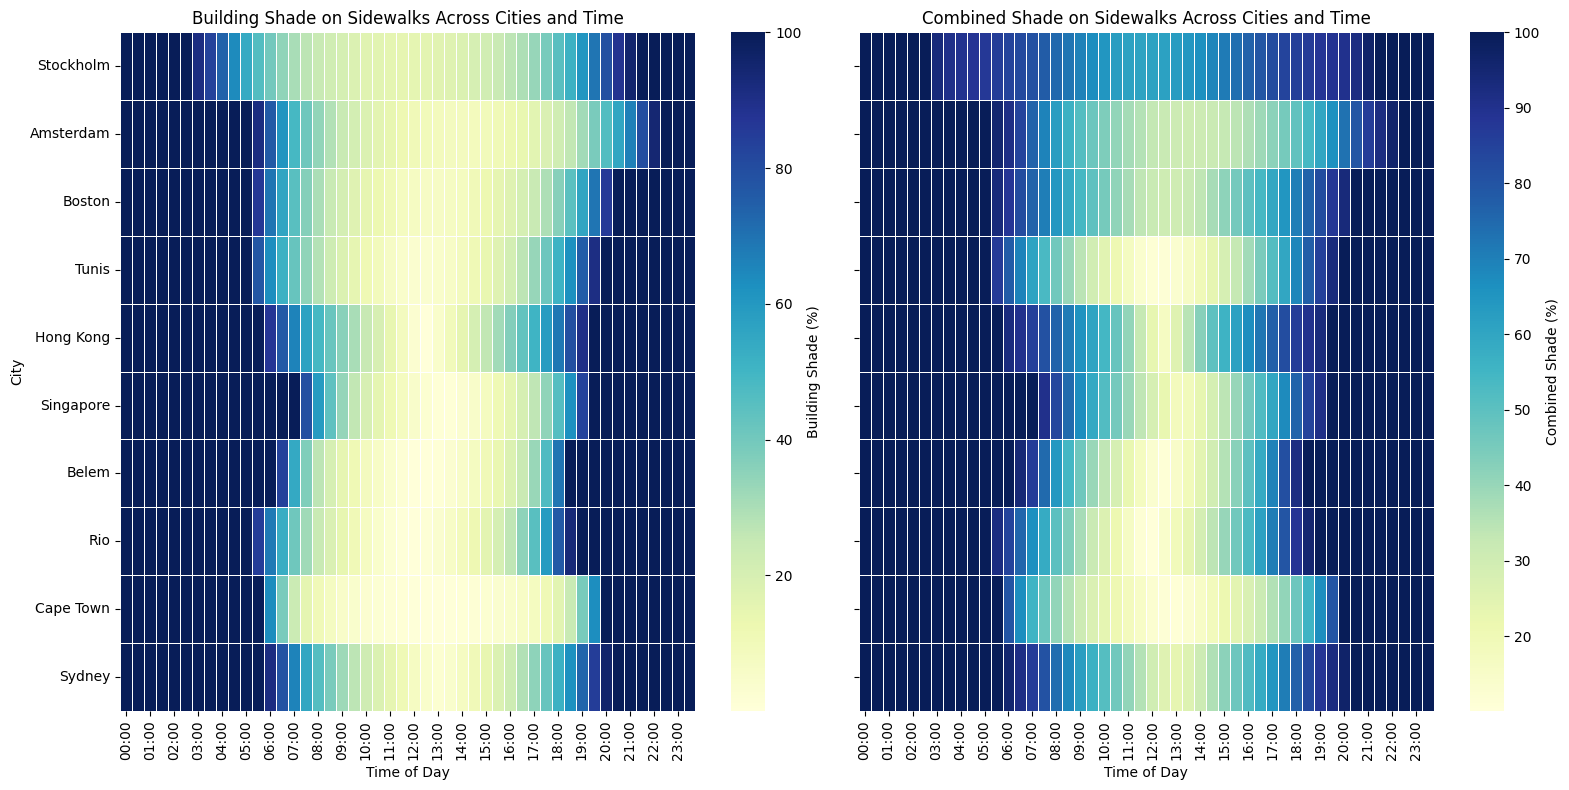

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two heatmaps arranged side by side, sharing the y-axis (cities)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Building shade heatmap on the left
sns.heatmap(
    building_shade_df, 
    ax=axes[0], 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Building Shade (%)'},
    linewidths=0.5
)
axes[0].set_title("Building Shade on Sidewalks Across Cities and Time")
axes[0].set_ylabel("City")
axes[0].set_xlabel("Time of Day")

# Tree shade heatmap on the right
sns.heatmap(
    tree_shade_df, 
    ax=axes[1], 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Combined Shade (%)'},
    linewidths=0.5
)
axes[1].set_title("Combined Shade on Sidewalks Across Cities and Time")
axes[1].set_xlabel("Time of Day")
# No need to set the y-label on the right since it's shared

plt.tight_layout()
plt.show()

### Two Cities Only

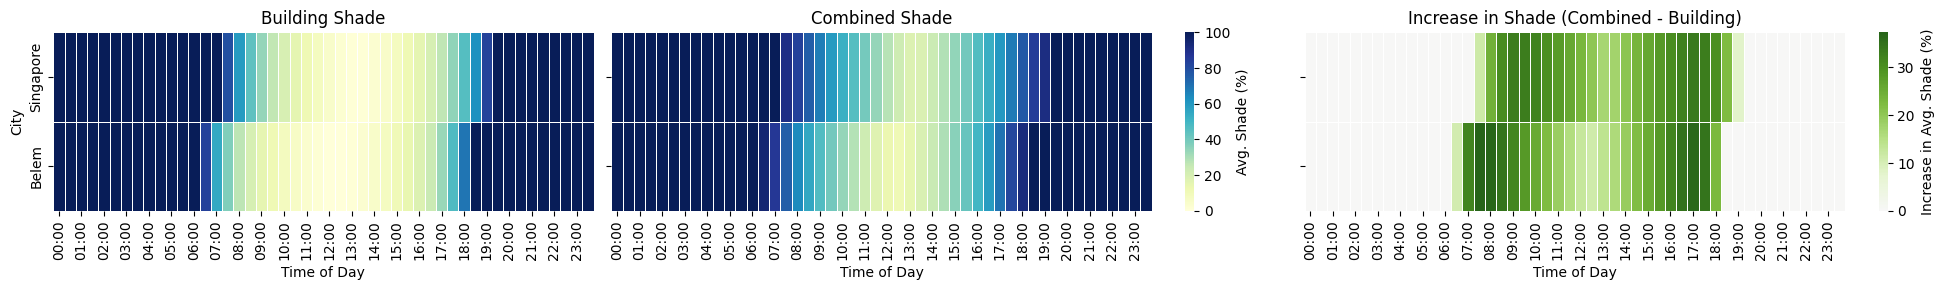

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the comparison cities
cities_to_compare = ["Singapore", "Belem"]

# Filter the DataFrames to include only the comparison cities.
comparison_building = building_shade_df.loc[cities_to_compare]
comparison_tree = tree_shade_df.loc[cities_to_compare]

# Compute the difference between the filtered tree and building shade.
comparison_diff = comparison_tree - comparison_building

# Define a common scale for the building and combined shade heatmaps.
shade_vmin = 0
shade_vmax = 100

# Create a figure with three subplots. Adjust width ratios as needed.
fig, axes = plt.subplots(1, 3, figsize=(20, 3), sharey=True, 
                           gridspec_kw={'width_ratios': [0.8, 1, 1]})

# Plot 1: Building shade heatmap (no colorbar)
sns.heatmap(
    comparison_building,
    ax=axes[0],
    cmap="YlGnBu",
    vmin=shade_vmin,
    vmax=shade_vmax,
    cbar=False,  # remove the colorbar here
    linewidths=0.5
)
axes[0].set_title("Building Shade")
axes[0].set_ylabel("City")
axes[0].set_xlabel("Time of Day")

# Plot 2: Combined (Tree) shade heatmap (with colorbar)
sns.heatmap(
    comparison_tree,
    ax=axes[1],
    cmap="YlGnBu",
    vmin=shade_vmin,
    vmax=shade_vmax,
    cbar_kws={'label': 'Avg. Shade (%)'},
    linewidths=0.5
)
axes[1].set_title("Combined Shade")
axes[1].set_xlabel("Time of Day")

# Plot 3: Difference heatmap (with colorbar)
sns.heatmap(
    comparison_diff,
    ax=axes[2],
    cmap="PiYG",  # diverging colormap for differences
    center=0,         # center the colormap at 0 for the difference plot
    cbar_kws={'label': 'Increase in Avg. Shade (%)'},
    linewidths=0.5
)
axes[2].set_title("Increase in Shade (Combined - Building)")
axes[2].set_xlabel("Time of Day")

plt.tight_layout()
plt.show()

### One city only

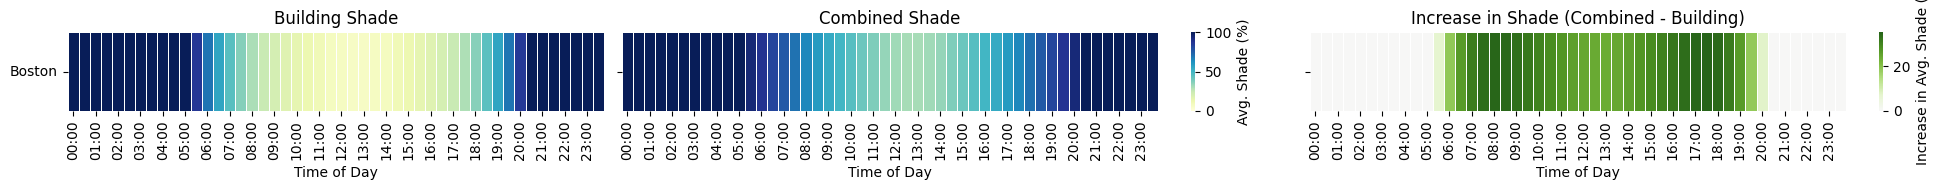

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the comparison cities
cities_to_compare = ["Boston"]

# cities_to_compare = ["Boston"]

# Filter the DataFrames to include only the comparison cities.
comparison_building = building_shade_df.loc[cities_to_compare]
comparison_tree = tree_shade_df.loc[cities_to_compare]

# Compute the difference between the filtered tree and building shade.
comparison_diff = comparison_tree - comparison_building

# Define a common scale for the building and combined shade heatmaps.
shade_vmin = 0
shade_vmax = 100

# Create a figure with three subplots. Adjust width ratios as needed.
fig, axes = plt.subplots(1, 3, figsize=(20, 2), sharey=True, 
                           gridspec_kw={'width_ratios': [0.8, 1, 1]})

# Plot 1: Building shade heatmap (no colorbar)
sns.heatmap(
    comparison_building,
    ax=axes[0],
    cmap="YlGnBu",
    vmin=shade_vmin,
    vmax=shade_vmax,
    cbar=False,  # remove the colorbar here
    linewidths=0.5
)
axes[0].set_title("Building Shade")
# axes[0].set_ylabel("City")
axes[0].set_xlabel("Time of Day")

# Plot 2: Combined (Tree) shade heatmap (with colorbar)
sns.heatmap(
    comparison_tree,
    ax=axes[1],
    cmap="YlGnBu",
    vmin=shade_vmin,
    vmax=shade_vmax,
    cbar_kws={'label': 'Avg. Shade (%)'},
    linewidths=0.5
)
axes[1].set_title("Combined Shade")
axes[1].set_xlabel("Time of Day")

# Plot 3: Difference heatmap (with colorbar)
sns.heatmap(
    comparison_diff,
    ax=axes[2],
    cmap="PiYG",  # diverging colormap for differences
    center=0,         # center the colormap at 0 for the difference plot
    cbar_kws={'label': 'Increase in Avg. Shade (%)'},
    linewidths=0.5
)
axes[2].set_title("Increase in Shade (Combined - Building)")
axes[2].set_xlabel("Time of Day")

for ax in axes:
    ax.tick_params(axis='y', labelrotation=0)

plt.tight_layout()
plt.show()

## Additional Contribution Trees

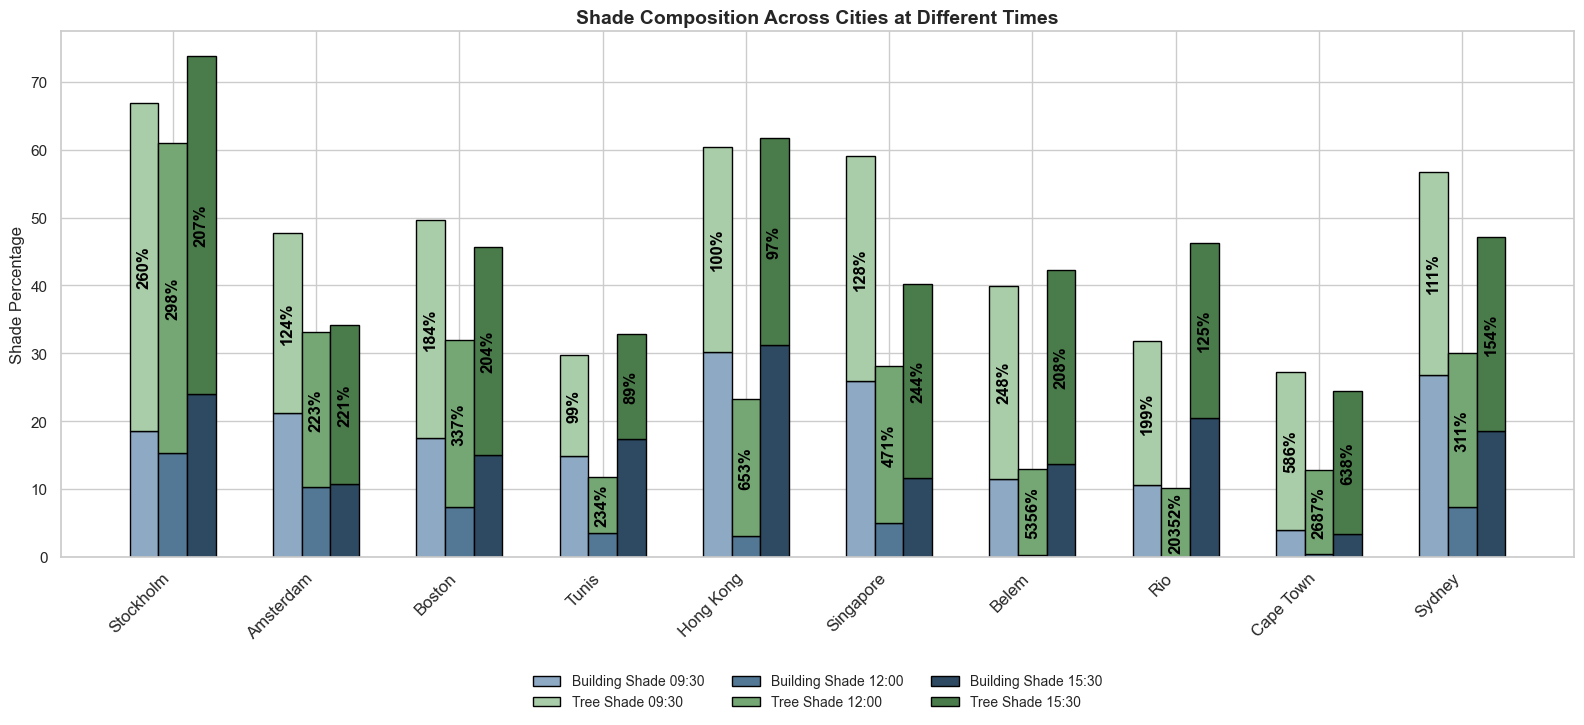

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

# Use Seaborn's theme for a modern look
sns.set_theme(style="whitegrid")

# Define the time intervals you want to compare
time_intervals = ["09:30", "12:00", "15:30"]
# Get the column indices for these time labels in the DataFrame
time_indices = [building_shade_df.columns.get_loc(t) for t in time_intervals]

# Prepare data for grouped bar chart
cities = building_shade_df.index.tolist()
x = np.arange(len(cities))  # x positions for cities
bar_width = 0.2             # width of each bar
offsets = np.linspace(-bar_width, bar_width, len(time_intervals))  # Offsets for each time interval

# Define color palettes for building and tree shade components
colors_building = ["#8DA9C4", "#537895", "#2E4A62"]
colors_tree = ["#A9CDA9", "#74A774", "#4A7B4A"]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Plot data for each time interval and annotate percentage increase inside the tree bar
for i, (time_idx, time_label) in enumerate(zip(time_indices, time_intervals)):
    # Retrieve the building shade values and compute the additional tree contribution
    building_values = building_shade_df.iloc[:, time_idx]
    tree_values = tree_shade_df.iloc[:, time_idx] - building_shade_df.iloc[:, time_idx]
    
    # Plot the building shade as a bar
    ax.bar(x + offsets[i],
           building_values,
           bar_width,
           color=colors_building[i],
           edgecolor='black')
    
    # Plot the tree shade stacked on top of the building shade
    ax.bar(x + offsets[i],
           tree_values,
           bar_width,
           bottom=building_values,
           color=colors_tree[i],
           edgecolor='black')
    
    # Annotate the percentage increase within the tree bar segment
    for pos, b, t in zip(x + offsets[i], building_values, tree_values):
        # If the building shade is greater than zero, calculate the percentage increase
        if b > 0:
            percentage_increase = (t / b) * 100
            # Compute y-position at the center of the tree shade segment
            y_text = b + t / 2
            ax.text(pos, y_text, f"{percentage_increase:.0f}%",
                    ha='center', va='center',
                    rotation=90, fontweight='bold',
                    color='black')
        else:
            # If building shade is zero, insert a placeholder "N/A"
            y_text = t / 2
            ax.text(pos, y_text, "N/A",
                    ha='center', va='center',
                    rotation=90, fontweight='bold',
                    color='red')

# Create custom legend entries using Patch so we avoid duplicate legend items
legend_entries = []
for i, time_label in enumerate(time_intervals):
    legend_entries.append(Patch(facecolor=colors_building[i],
                                edgecolor='black',
                                label=f"Building Shade {time_label}"))
    legend_entries.append(Patch(facecolor=colors_tree[i],
                                edgecolor='black',
                                label=f"Tree Shade {time_label}"))

# Place the legend at the bottom outside of the plot area
ax.legend(handles=legend_entries,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.2),
          ncol=3,
          frameon=False,
          fontsize=10)

# Set axis labels, title, and tick parameters for clarity
ax.set_xticks(x)
ax.set_xticklabels(cities, rotation=45, ha='right', fontsize=12)
ax.set_ylabel("Shade Percentage", fontsize=12)
ax.set_title("Shade Composition Across Cities at Different Times", fontsize=14, fontweight='bold')

# Adjust layout to ensure nothing gets cut off (especially the legend)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

## Maps

### Single map

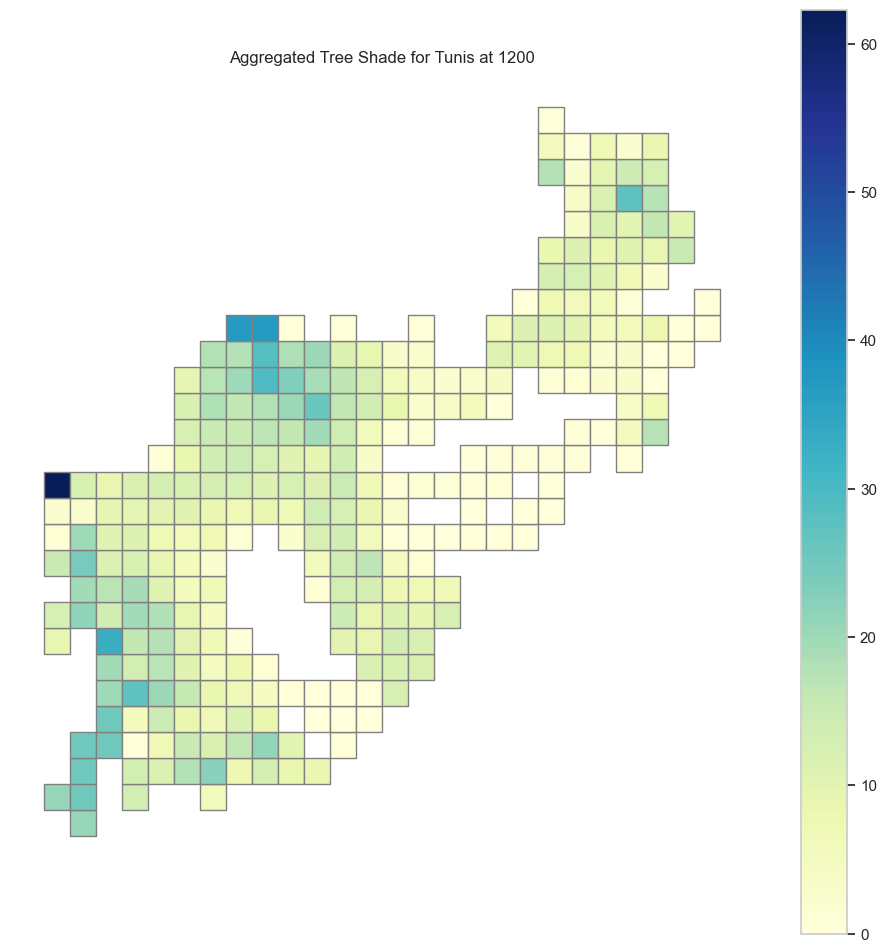

In [7]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

def create_grid(gdf, cell_size):
    """
    Create a grid (as a GeoDataFrame) covering the extent of gdf,
    with square cells of size cell_size (in the units of gdf's CRS).
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds
    cols = int(np.ceil((xmax - xmin) / cell_size))
    rows = int(np.ceil((ymax - ymin) / cell_size))
    
    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = box(xmin + i * cell_size, 
                       ymin + j * cell_size, 
                       xmin + (i + 1) * cell_size, 
                       ymin + (j + 1) * cell_size)
            grid_cells.append(cell)
    
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)
    return grid

def plot_shade_map(city, shade_type, time_str, cell_size):
    """
    Plot an aggregated shade map for a given city.
    
    Parameters:
    - city: Name of the city (must be a key in combined_city_data and city_details)
    - shade_type: Either "building" or "tree" (controls which shade column to use)
    - time_str: A string representing the time in HHMM format (e.g., "1200")
    - cell_size: The grid cell size (in the units of the city's projected CRS)
    """
    # Retrieve the city's sidewalk GeoDataFrame and details.
    if city not in combined_city_data:
        raise ValueError(f"City '{city}' not found in combined_city_data.")
    city_gdf = combined_city_data[city]
    
    if city not in city_details:
        raise ValueError(f"City '{city}' not found in city_details.")
    date_str = city_details[city]["date"].replace("-", "")  # e.g., "20251221"
    
    # Construct the appropriate shade column name.
    shade_column = f"{date_str}_{shade_type}_shade_percent_at_{time_str}"
    if shade_column not in city_gdf.columns:
        raise ValueError(f"Column '{shade_column}' not found in the {city} data.")
    
    # Work on a copy of the data and create a uniform column for the shade value.
    city_gdf = city_gdf.copy()
    city_gdf["shade_value"] = city_gdf[shade_column]
    
    # Reproject to a projected CRS if necessary so that our cell_size is meaningful.
    if city_gdf.crs.is_geographic:
        # For simplicity, we use Web Mercator (EPSG:3857). You may choose a more appropriate projection.
        city_gdf = city_gdf.to_crs(epsg=3857)
    
    # Create a grid covering the extent of the city's sidewalk data.
    grid = create_grid(city_gdf, cell_size)
    
    # Spatially join the sidewalk polygons with the grid.
    joined = gpd.sjoin(city_gdf, grid, how="inner", predicate="intersects")
    
    # For each grid cell, compute the average shade value.
    grid_avg = joined.groupby("index_right")["shade_value"].mean()
    
    # Map the aggregated values back onto the grid GeoDataFrame.
    grid["avg_shade"] = grid.index.map(grid_avg)
    
    # Plot the aggregated grid as a heatmap.
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    grid.plot(column="avg_shade", cmap="YlGnBu", legend=True, ax=ax, edgecolor="grey")
    ax.set_title(f"Aggregated {shade_type.capitalize()} Shade for {city} at {time_str}")
    ax.set_axis_off()  # Optionally hide the axis for a cleaner look.
    plt.show()

# Example usage:
# To generate a map for Sydney, showing the tree shade at 12:00 using a 150-meter grid:
plot_shade_map(city="Tunis", shade_type="tree", time_str="1200", cell_size=1000)

### Comparison maps

#### Buildings and trees for single city

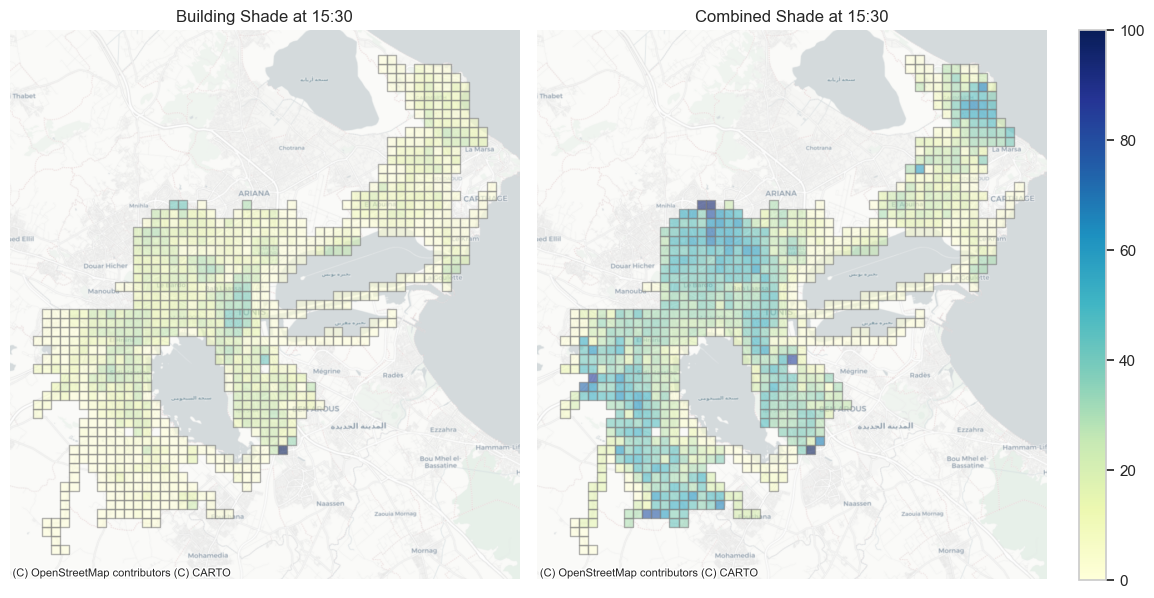

In [8]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx  # Import contextily for basemaps

def create_grid(gdf, cell_size):
    """
    Create a grid (as a GeoDataFrame) covering the extent of gdf,
    with square cells of size cell_size (in the units of gdf's CRS).
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds
    cols = int(np.ceil((xmax - xmin) / cell_size))
    rows = int(np.ceil((ymax - ymin) / cell_size))
    
    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = box(
                xmin + i * cell_size, 
                ymin + j * cell_size, 
                xmin + (i + 1) * cell_size, 
                ymin + (j + 1) * cell_size
            )
            grid_cells.append(cell)
    
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)
    return grid

def aggregate_shade_grid(gdf, shade_column, cell_size):
    """
    Aggregate the shade values from the given GeoDataFrame onto a grid.
    
    Parameters:
    - gdf: The GeoDataFrame with sidewalk polygons.
    - shade_column: The column name (string) containing the shade percentage.
    - cell_size: The grid cell size (in the units of the gdf's CRS).
    
    Returns:
    - grid: A GeoDataFrame containing the grid cells with an added column 'avg_shade'.
    """
    gdf_copy = gdf.copy()
    gdf_copy["shade_value"] = gdf_copy[shade_column]
    
    # Ensure data is in a projected CRS so that cell_size is meaningful.
    if gdf_copy.crs.is_geographic:
        # Using Web Mercator (EPSG:3857) for simplicity—choose an appropriate projection if needed.
        gdf_copy = gdf_copy.to_crs(epsg=3857)
    
    grid = create_grid(gdf_copy, cell_size)
    joined = gpd.sjoin(gdf_copy, grid, how="inner", predicate="intersects")
    grid_avg = joined.groupby("index_right")["shade_value"].mean()
    grid["avg_shade"] = grid.index.map(grid_avg)
    return grid

def plot_dual_shade_maps(city, time_str, cell_size, add_basemap=True):
    """
    Create side-by-side aggregated shade maps for a given city and time.
    
    This function plots two maps:
      - Left: Aggregated building shade (colorbar removed).
      - Right: Aggregated combined (tree) shade (colorbar displayed).
    
    Both maps are produced using the same color scale (0 to 100) and, optionally,
    include a basemap from Contextily (CartoDB DarkMatter).
    
    Parameters:
    - city: Name of the city (must be a key in combined_city_data and city_details).
    - time_str: A string representing the time in HHMM format (e.g., "1200").
    - cell_size: The grid cell size (in the units of the city's projected CRS).
    - add_basemap: Boolean flag. If True, adds a Contextily basemap to each subplot.
    """
    # Retrieve the city's sidewalk GeoDataFrame.
    if city not in combined_city_data:
        raise ValueError(f"City '{city}' not found in combined_city_data.")
    city_gdf = combined_city_data[city]
    
    # Retrieve the city's details.
    if city not in city_details:
        raise ValueError(f"City '{city}' not found in city_details.")
    date_str = city_details[city]["date"].replace("-", "")  # e.g., "20251221"
    
    # Construct the column names for building shade and tree shade.
    building_shade_column = f"{date_str}_building_shade_percent_at_{time_str}"
    tree_shade_column = f"{date_str}_tree_shade_percent_at_{time_str}"
    
    if building_shade_column not in city_gdf.columns:
        raise ValueError(f"Column '{building_shade_column}' not found in {city} data.")
    if tree_shade_column not in city_gdf.columns:
        raise ValueError(f"Column '{tree_shade_column}' not found in {city} data.")
    
    # Aggregate the data for both shade types.
    grid_building = aggregate_shade_grid(city_gdf, building_shade_column, cell_size)
    grid_tree = aggregate_shade_grid(city_gdf, tree_shade_column, cell_size)
    
    # Create a formatted timestring
    formatted_time = f"{time_str[:2]}:{time_str[2:]}"


    # Create a figure with two subplots (side by side - 12, 6 is the original).
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [0.8, 1]})
    
    # Plot the building shade map (without colorbar).
    grid_building.plot(
        column="avg_shade", cmap="YlGnBu", legend=False, ax=axes[0],
        edgecolor="grey", vmin=0, vmax=100, alpha=0.6
    )
    axes[0].set_title(f"Building Shade at {formatted_time}")
    axes[0].set_axis_off()
    
    # Optionally add a basemap to the left plot.
    if add_basemap:
        ctx.add_basemap(axes[0], source=ctx.providers.CartoDB.Positron, crs=grid_building.crs)
    
    # Plot the tree (combined) shade map (with colorbar).
    grid_tree.plot(
        column="avg_shade", cmap="YlGnBu", legend=True, ax=axes[1],
        edgecolor="grey", vmin=0, vmax=100, alpha=0.6
    )
    axes[1].set_title(f"Combined Shade at {formatted_time}")
    axes[1].set_axis_off()
    
    # Optionally add a basemap to the right plot.
    if add_basemap:
        ctx.add_basemap(axes[1], source=ctx.providers.CartoDB.Positron, crs=grid_tree.crs)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# This will generate two side-by-side maps for Sydney at 12:00 using a 150-meter grid cell size.
# Set add_basemap=False to disable the basemap.
plot_dual_shade_maps(city="Tunis", time_str="1530", cell_size=500, add_basemap=True)

#### Comparing cities side by side

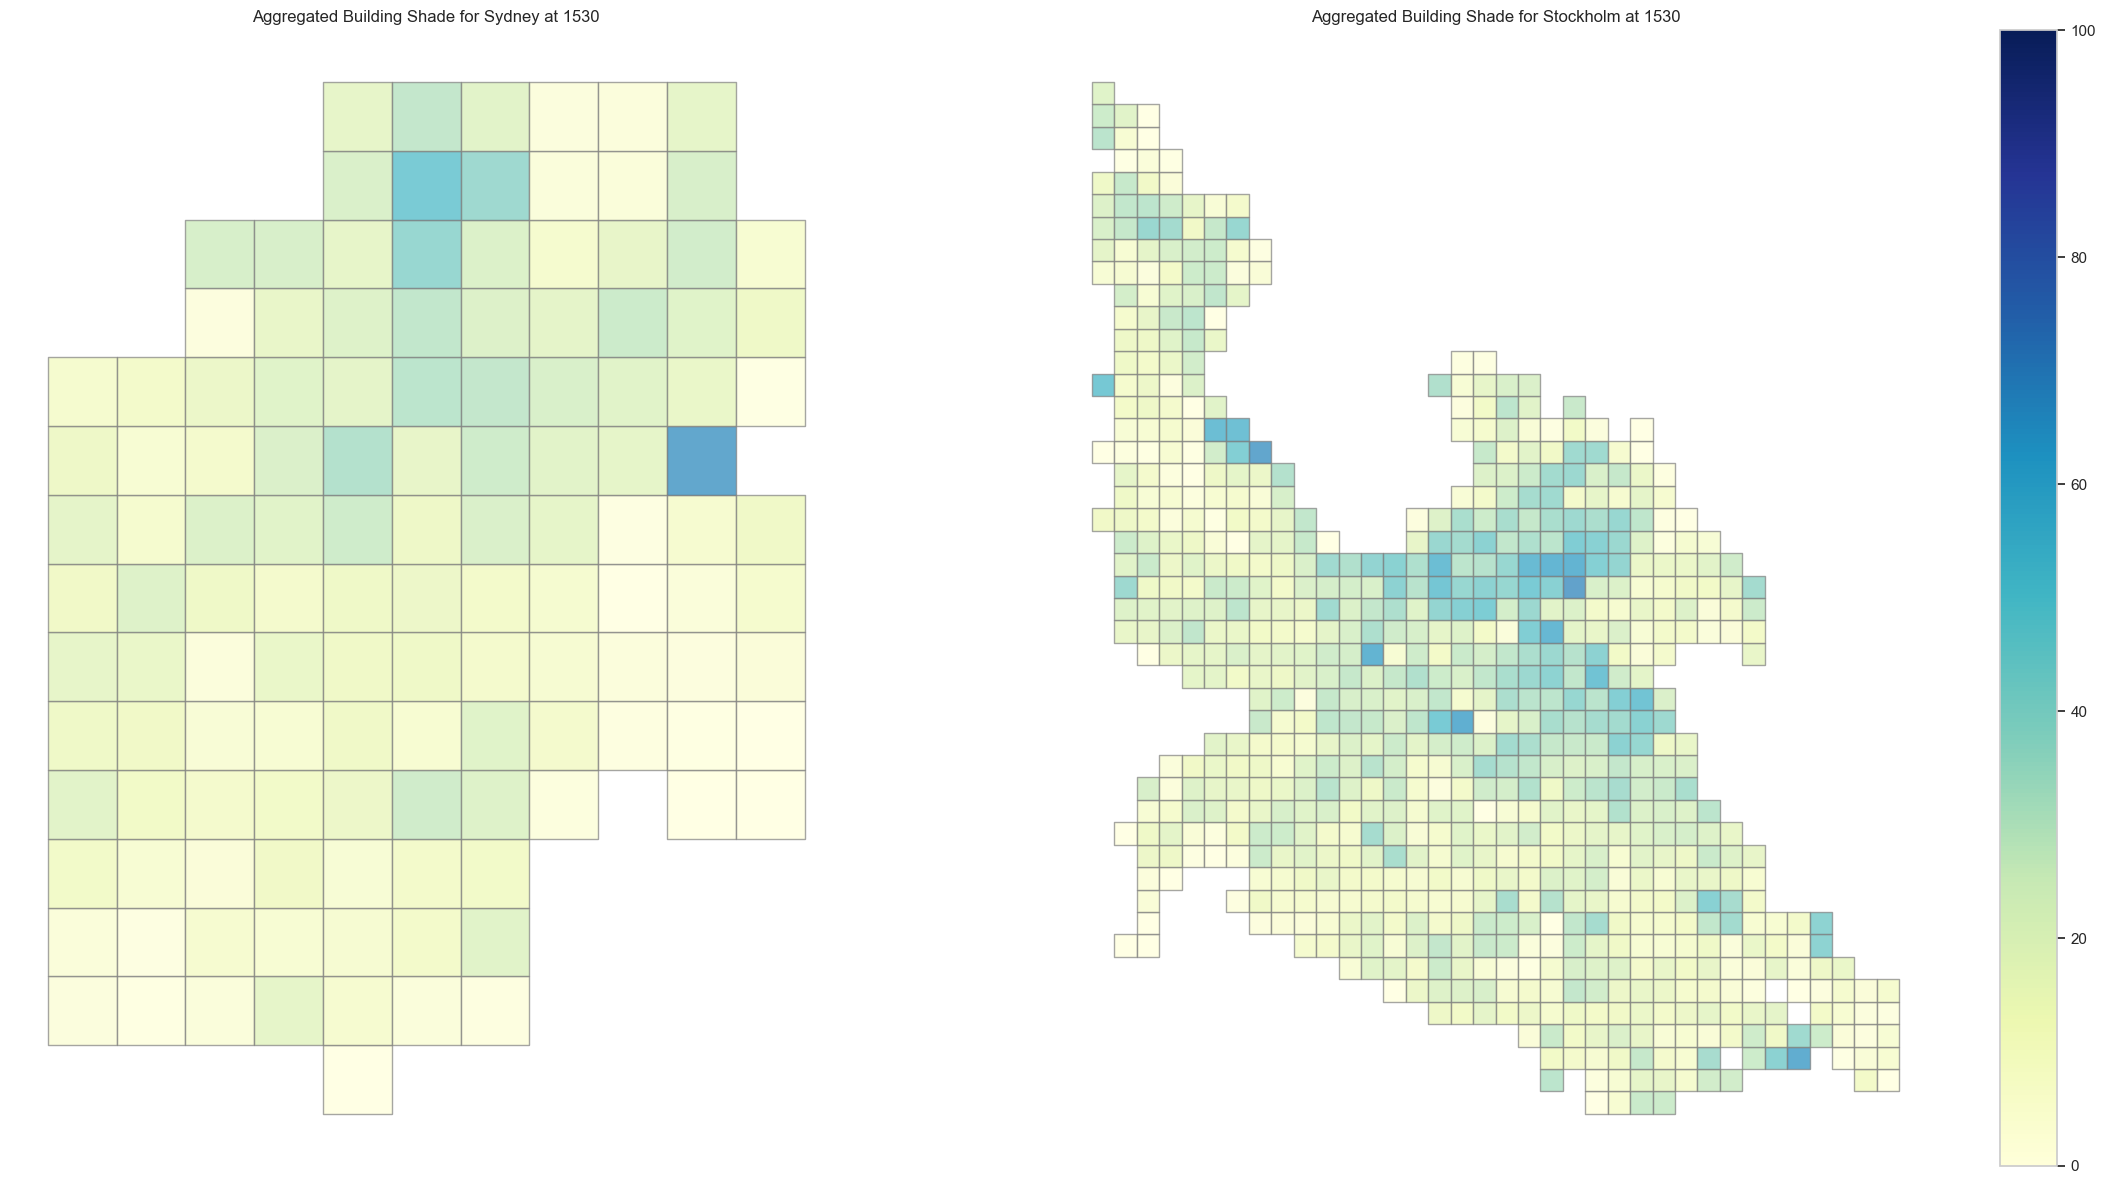

In [9]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx  # Import contextily for basemaps

def create_grid(gdf, cell_size):
    """
    Create a grid (as a GeoDataFrame) covering the extent of gdf,
    with square cells of size cell_size (in the units of gdf's CRS).
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds
    cols = int(np.ceil((xmax - xmin) / cell_size))
    rows = int(np.ceil((ymax - ymin) / cell_size))
    
    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = box(
                xmin + i * cell_size, 
                ymin + j * cell_size, 
                xmin + (i + 1) * cell_size, 
                ymin + (j + 1) * cell_size
            )
            grid_cells.append(cell)
    
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)
    return grid

def aggregate_shade_grid(gdf, shade_column, cell_size):
    """
    Aggregate the shade values from the given GeoDataFrame onto a grid.
    
    Parameters:
    - gdf: The GeoDataFrame with sidewalk polygons.
    - shade_column: The column name (string) containing the shade percentage.
    - cell_size: The grid cell size (in the units of the gdf's CRS).
    
    Returns:
    - grid: A GeoDataFrame containing the grid cells with an added column 'avg_shade'.
    """
    gdf_copy = gdf.copy()
    gdf_copy["shade_value"] = gdf_copy[shade_column]
    
    # Ensure data is in a projected CRS so that cell_size is meaningful.
    if gdf_copy.crs.is_geographic:
        # Using Web Mercator (EPSG:3857) for simplicity—choose an appropriate projection if needed.
        gdf_copy = gdf_copy.to_crs(epsg=3857)
    
    grid = create_grid(gdf_copy, cell_size)
    joined = gpd.sjoin(gdf_copy, grid, how="inner", predicate="intersects")
    grid_avg = joined.groupby("index_right")["shade_value"].mean()
    grid["avg_shade"] = grid.index.map(grid_avg)
    return grid

def plot_comparison_shade_maps(city1, city2, shade_type, time_str, cell_size, add_basemap=True):
    """
    Create side-by-side aggregated shade maps for two different cities.
    
    This function compares the selected shade type ("building" or "tree")
    for two cities at a given time (HHMM format) using the same color scale (0 to 100).
    An optional basemap (using Contextily) can be added.
    
    Parameters:
    - city1: Name of the first city (must be a key in combined_city_data and city_details).
    - city2: Name of the second city.
    - shade_type: Either "building" or "tree" (determines which shade column to use).
    - time_str: A string representing the time in HHMM format (e.g., "1200").
    - cell_size: The grid cell size (in the units of the city's projected CRS).
    - add_basemap: Boolean flag; if True, a basemap is added to each subplot.
    """
    # Retrieve and validate data for the first city.
    if city1 not in combined_city_data:
        raise ValueError(f"City '{city1}' not found in combined_city_data.")
    city1_gdf = combined_city_data[city1]
    if city1 not in city_details:
        raise ValueError(f"City '{city1}' not found in city_details.")
    date_str1 = city_details[city1]["date"].replace("-", "")
    shade_column1 = f"{date_str1}_{shade_type}_shade_percent_at_{time_str}"
    if shade_column1 not in city1_gdf.columns:
        raise ValueError(f"Column '{shade_column1}' not found in {city1} data.")
    
    # Retrieve and validate data for the second city.
    if city2 not in combined_city_data:
        raise ValueError(f"City '{city2}' not found in combined_city_data.")
    city2_gdf = combined_city_data[city2]
    if city2 not in city_details:
        raise ValueError(f"City '{city2}' not found in city_details.")
    date_str2 = city_details[city2]["date"].replace("-", "")
    shade_column2 = f"{date_str2}_{shade_type}_shade_percent_at_{time_str}"
    if shade_column2 not in city2_gdf.columns:
        raise ValueError(f"Column '{shade_column2}' not found in {city2} data.")
    
    # Aggregate the shade data for both cities.
    grid1 = aggregate_shade_grid(city1_gdf, shade_column1, cell_size)
    grid2 = aggregate_shade_grid(city2_gdf, shade_column2, cell_size)
    
    # Create a figure with two subplots.
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))
    
    # Plot the first city's aggregated shade map (no colorbar).
    grid1.plot(
        column="avg_shade", cmap="YlGnBu", legend=False, ax=axes[0],
        edgecolor="grey", vmin=0, vmax=100, alpha=0.7
    )
    axes[0].set_title(f"Aggregated {shade_type.capitalize()} Shade for {city1} at {time_str}")
    axes[0].set_axis_off()
    if add_basemap:
        ctx.add_basemap(axes[0], source=ctx.providers.CartoDB.DarkMatter, crs=grid1.crs)
    
    # Plot the second city's aggregated shade map (with colorbar).
    grid2.plot(
        column="avg_shade", cmap="YlGnBu", legend=True, ax=axes[1],
        edgecolor="grey", vmin=0, vmax=100, alpha=0.7
    )
    axes[1].set_title(f"Aggregated {shade_type.capitalize()} Shade for {city2} at {time_str}")
    axes[1].set_axis_off()
    if add_basemap:
        ctx.add_basemap(axes[1], source=ctx.providers.CartoDB.DarkMatter, crs=grid2.crs)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# This will generate side-by-side maps comparing Sydney and Cape Town
# for building shade at 12:00 using a 150-meter grid cell size.
plot_comparison_shade_maps(city1="Sydney", city2="Stockholm", shade_type="building", time_str="1530", cell_size=500, add_basemap=False)

### Time series:

In [ ]:
import math
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import contextily as ctx  # Import contextily for basemaps

def create_grid(gdf, cell_size):
    """
    Create a grid (as a GeoDataFrame) covering the extent of gdf,
    with square cells of size cell_size (in the units of gdf's CRS).
    """
    xmin, ymin, xmax, ymax = gdf.total_bounds
    cols = int(np.ceil((xmax - xmin) / cell_size))
    rows = int(np.ceil((ymax - ymin) / cell_size))
    
    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = box(
                xmin + i * cell_size, 
                ymin + j * cell_size, 
                xmin + (i + 1) * cell_size, 
                ymin + (j + 1) * cell_size
            )
            grid_cells.append(cell)
    
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)
    return grid

def aggregate_shade_grid(gdf, shade_column, cell_size):
    """
    Aggregate the shade values from the given GeoDataFrame onto a grid.
    
    Parameters:
    - gdf: The GeoDataFrame with sidewalk polygons.
    - shade_column: The column name (string) containing the shade percentage.
    - cell_size: The grid cell size (in the units of the gdf's CRS).
    
    Returns:
    - grid: A GeoDataFrame containing the grid cells with an added column 'avg_shade'.
    """
    gdf_copy = gdf.copy()
    gdf_copy["shade_value"] = gdf_copy[shade_column]
    
    # Ensure data is in a projected CRS so that cell_size is meaningful.
    if gdf_copy.crs.is_geographic:
        # Using Web Mercator (EPSG:3857) for simplicity—choose an appropriate projection if needed.
        gdf_copy = gdf_copy.to_crs(epsg=3857)
    
    grid = create_grid(gdf_copy, cell_size)
    joined = gpd.sjoin(gdf_copy, grid, how="inner", predicate="intersects")
    grid_avg = joined.groupby("index_right")["shade_value"].mean()
    grid["avg_shade"] = grid.index.map(grid_avg)
    return grid

def plot_overview_shade_patterns(city, shade_type, time_steps, cell_size, add_basemap=True):
    """
    Create an overview plot showing aggregated shade maps for a given city over multiple timesteps.
    
    Parameters:
    - city: Name of the city (must be a key in combined_city_data and city_details).
    - shade_type: Either "building" or "tree" (determines which shade column to use).
    - time_steps: List of time strings in HHMM format (e.g., ["0900", "1200", "1500", "1800", "2100", "0000"]).
    - cell_size: The grid cell size (in the units of the city's projected CRS).
    - add_basemap: Boolean flag; if True, adds a Contextily basemap to each subplot.
    
    The function arranges the maps in 2 rows. For example, 6 timesteps will produce 2 rows with 3 columns,
    and 8 timesteps will produce 2 rows with 4 columns.
    """
    # Validate city existence
    if city not in combined_city_data:
        raise ValueError(f"City '{city}' not found in combined_city_data.")
    city_gdf = combined_city_data[city]
    if city not in city_details:
        raise ValueError(f"City '{city}' not found in city_details.")
    date_str = city_details[city]["date"].replace("-", "")  # e.g., "20251221"
    
    n_time = len(time_steps)
    nrows = 2
    ncols = math.ceil(n_time / nrows)
    
    # Create the subplot grid.
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 8))
    # Flatten the array for easy iteration.
    axes = axes.flatten()
    
    for i, time_str in enumerate(time_steps):
        # Construct the shade column name.
        shade_column = f"{date_str}_{shade_type}_shade_percent_at_{time_str}"
        if shade_column not in city_gdf.columns:
            raise ValueError(f"Column '{shade_column}' not found in {city} data.")
        # Aggregate the shade data.
        grid = aggregate_shade_grid(city_gdf, shade_column, cell_size)
        ax = axes[i]
        grid.plot(
            column="avg_shade", cmap="YlGnBu", legend=False, ax=ax,
            edgecolor="grey", vmin=0, vmax=100, alpha=0.7
        )
        ax.set_title(f"{city} {shade_type.capitalize()} Shade at {time_str}")
        ax.set_axis_off()
        if add_basemap:
            ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter, crs=grid.crs)
    
    # Turn off any unused axes.
    for j in range(n_time, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

# Example usage:
# # This will create an overview plot for Stockholm showing 6 timesteps arranged in 2 rows and 3 columns.
# # You can change the time_steps list as needed.
# time_steps = ["0900", "1100", "1200", "1400", "1500", "1800"]
# plot_overview_shade_patterns(city="Sydney", shade_type="building", time_steps=time_steps, cell_size=200, add_basemap=False)

In [ ]:
# Example usage:
# This will create an overview plot for Stockholm showing 6 timesteps arranged in 2 rows and 3 columns.
# You can change the time_steps list as needed.
time_steps = ["0900", "1030", "1200", "1330", "1500", "1730"]
plot_overview_shade_patterns(city="Cape Town", shade_type="tree", time_steps=time_steps, cell_size=1000, add_basemap=False)